In [1]:
# if needed
#!conda install -y -c conda-forge imbalanced-learn 

# Classification imbalance

If the classes in the training data are imbalanced, the learning algorithm favors the overrepresented class.

If only 1% of your data belongs to class B, the algorithm can predict class A every time and have 99% accuracy.  If it's able to correctly classify only the most obvious Bs, maybe it gets 99.3% accuracy.  In some cases better identification of the minority class is desired.

We'll use the `imblearn` package here https://imbalanced-learn.org/stable/api.html

## Generate sample data

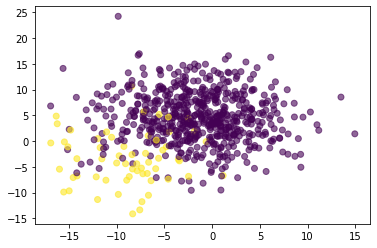

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN, SMOTETomek

# Generate imbalanced with 10x as many samples in first class
X, y = make_blobs(n_samples=[600, 60], random_state=1, cluster_std=5)

p = plt.scatter(X[:, 0], X[:, 1], c=y, alpha=.6)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Counter(y_train)

Counter({0: 451, 1: 44})

## Logistic regression on unmodified data

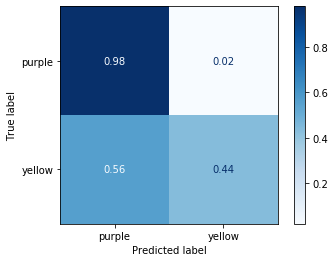

In [4]:
model = LogisticRegression(random_state=1)
model.fit(X_train, y_train)

p = plot_confusion_matrix(model, X_test, y_test,
                      display_labels=['purple', 'yellow'],
                      cmap=plt.cm.Blues,
                      normalize='true')

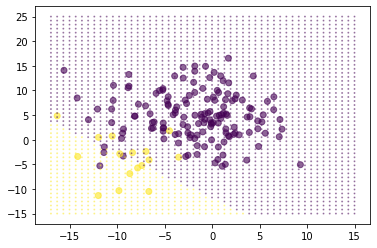

In [5]:
grid_X = np.array(np.meshgrid( 
    np.linspace(np.floor(X[:,0].min()), np.ceil(X[:,0].max()), 50),
    np.linspace(np.floor(X[:,1].min()), np.ceil(X[:,1].max()), 50)
)).T.reshape(-1,2)

grid_y_pred = model.predict(grid_X)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=.6)
p = plt.scatter(grid_X[:, 0], grid_X[:, 1], c=grid_y_pred, s=1, alpha=.4)

Purple has too much territory because in the contested area, there are ten times as many purples.

N.b. for logistic regression we can look at the trained parameters and draw the line separating the halves of the plane.  It's not that easy or possible in all models, so predicting over a grid is a general-purpose way to see the decision boundary.

## Random oversampling

Random oversampling randomly selects rows from the minority class, with replacement, and adds them to the training dataset.

This is a mindset similar to the bootstrap.

In [6]:
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 451, 1: 451})

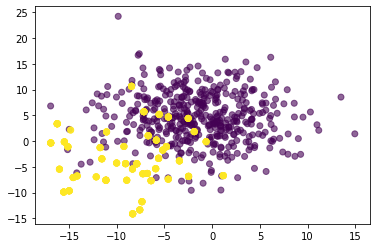

In [7]:
p = plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, alpha=.6)

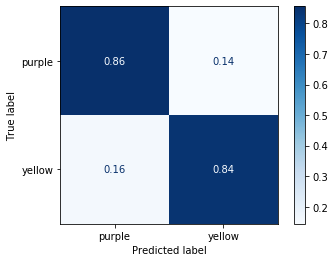

In [8]:
model = LogisticRegression(random_state=1)
model.fit(X_resampled, y_resampled)

p = plot_confusion_matrix(model, X_resampled, y_resampled,
                      display_labels=['purple', 'yellow'],
                      cmap=plt.cm.Blues,
                      normalize='true')

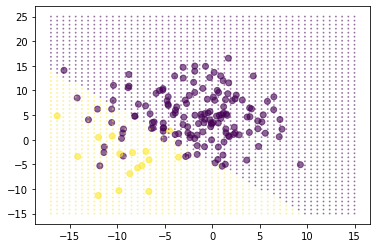

In [9]:
grid_y_pred = model.predict(grid_X)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=.6)
p = plt.scatter(grid_X[:, 0], grid_X[:, 1], c=grid_y_pred, s=1, alpha=.4)

## SMOTE

Synthetic Minority Oversampling Technique.  SMOTE augments the training data by synthesizing new samples of the minority class.  It takes a point, finds one of its $K$ nearest neighbors, and synthesizes a new point somewhere between these two.  The new point is added to the data set.

In [10]:
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(X_train, y_train)
from collections import Counter

Counter(y_resampled)

Counter({0: 451, 1: 451})

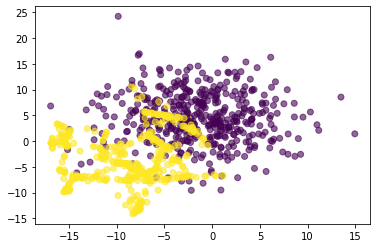

In [11]:
p = plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, alpha=.6)

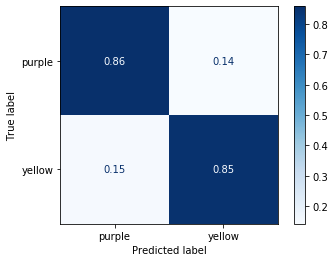

In [12]:
model = LogisticRegression(random_state=1)
model.fit(X_resampled, y_resampled)

p = plot_confusion_matrix(model, X_resampled, y_resampled,
                      display_labels=['purple', 'yellow'],
                      cmap=plt.cm.Blues,
                      normalize='true')

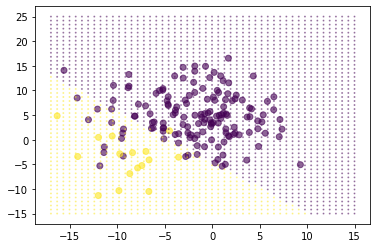

In [13]:
grid_y_pred = model.predict(grid_X)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=.6)
p = plt.scatter(grid_X[:, 0], grid_X[:, 1], c=grid_y_pred, s=1, alpha=.4)

## Random Undersampling

Random undersampling randomly discards rows of the majority class.

In [14]:
rus = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 44, 1: 44})

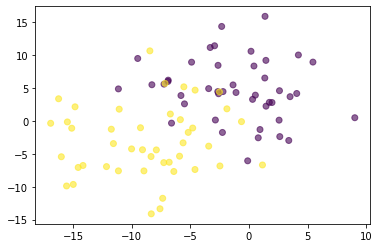

In [15]:
p = plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, alpha=.6)

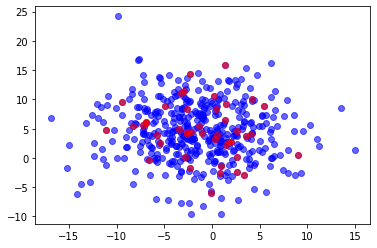

In [16]:
X_original_majority = X_train[y_train == 0, :]
X_resampled_majority = X_resampled[y_resampled == 0, :]

p = plt.scatter(X_original_majority[:, 0], X_original_majority[:, 1], c='blue', alpha=.6)
p = plt.scatter(X_resampled_majority[:, 0], X_resampled_majority[:, 1], c='red', alpha=.6)

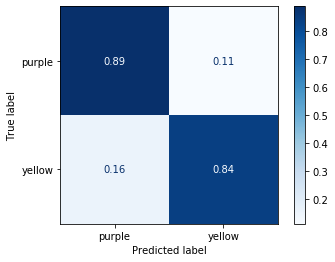

In [17]:
model = LogisticRegression(random_state=1)
model.fit(X_resampled, y_resampled)

p = plot_confusion_matrix(model, X_resampled, y_resampled,
                      display_labels=['purple', 'yellow'],
                      cmap=plt.cm.Blues,
                      normalize='true')

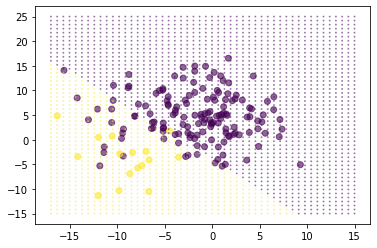

In [18]:
grid_y_pred = model.predict(grid_X)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=.6)
p = plt.scatter(grid_X[:, 0], grid_X[:, 1], c=grid_y_pred, s=1, alpha=.4)

## Cluster Centroid Undersampling

Cluster centroid undersampling undersamples the majority class by replacing a cluster of majority samples by the cluster centroid of a KMeans algorithm.

To keep only 100 samples out of 500, run a 100-means algorithm.  There are then 100 cluster centroids with an average of five points near them.  Throw out the 500 original data points and replace them with the 100 centroids.

In [19]:
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

from collections import Counter

Counter(y_resampled)

Counter({0: 44, 1: 44})

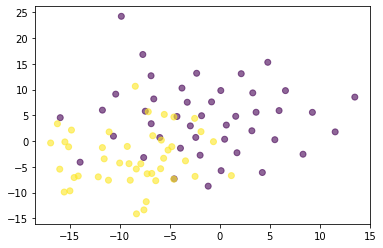

In [20]:
p = plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, alpha=.6)

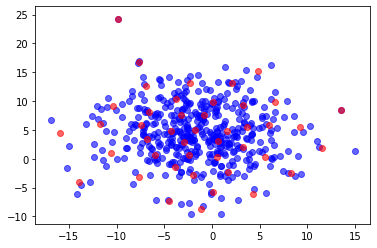

In [21]:
X_original_majority = X_train[y_train == 0, :]
X_resampled_majority = X_resampled[y_resampled == 0, :]

p = plt.scatter(X_original_majority[:, 0], X_original_majority[:, 1], c='blue', alpha=.6)
p = plt.scatter(X_resampled_majority[:, 0], X_resampled_majority[:, 1], c='red', alpha=.6)

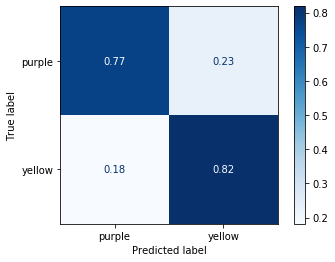

In [22]:
model = LogisticRegression(random_state=1)
model.fit(X_resampled, y_resampled)

p = plot_confusion_matrix(model, X_resampled, y_resampled,
                      display_labels=['purple', 'yellow'],
                      cmap=plt.cm.Blues,
                      normalize='true')

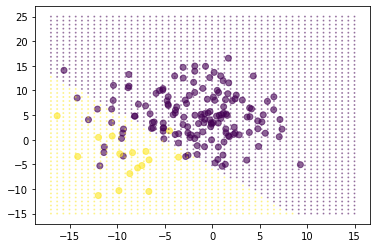

In [23]:
grid_y_pred = model.predict(grid_X)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=.6)
p = plt.scatter(grid_X[:, 0], grid_X[:, 1], c=grid_y_pred, s=1, alpha=.4)

## Combination methods

You can combine over- and under-sampling manually.  You can override the defaults of the samplers used above to, say, do half of each.  They can also be combined 

## SMOTEEEN

Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.

> This rule involves using k=3 nearest neighbors to locate those examples in a dataset that are misclassified and that are then removed. It can be applied to all classes or just those examples in the majority class.
(https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)

In [24]:
sm = SMOTEENN(random_state=1)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 330, 1: 361})

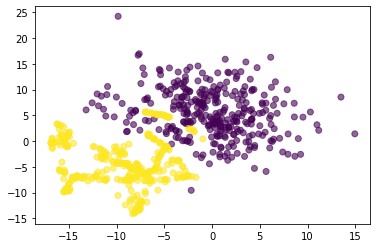

In [25]:
p = plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, alpha=.6)

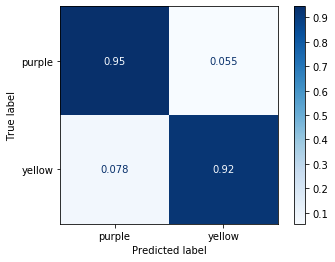

In [26]:
model = LogisticRegression(random_state=1)
model.fit(X_resampled, y_resampled)

p = plot_confusion_matrix(model, X_resampled, y_resampled,
                      display_labels=['purple', 'yellow'],
                      cmap=plt.cm.Blues,
                      normalize='true')

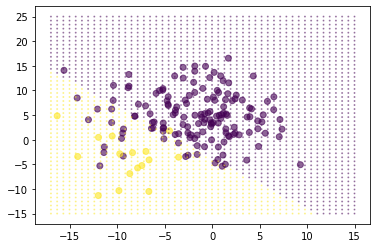

In [27]:
grid_y_pred = model.predict(grid_X)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=.6)
p = plt.scatter(grid_X[:, 0], grid_X[:, 1], c=grid_y_pred, s=1, alpha=.4)